\begin{align*}
F(x) &= \max_{1 \leq i \leq n} \left\{ v_i^T x + b_i \right\} \\
G(x) &= \max_{1 \leq j \leq m} \left\{ w_j^T x + c_j \right\} \\
h(x) &= F(x) - G(x) \\
h(x) &= \max_{1 \leq i \leq n} \left\{ v_i^T x + b_i \right\} - \max_{1 \leq j \leq m} \left\{ w_j^T x + c_j \right\}
\end{align*}

Goal:

For a given set of "true" values, $y_i$ associated with $x_i$,

\begin{equation*} \text{Minimize } d(y_i, h(x_i)) \end{equation*}

for all $i$ in some way.

Initial ideas:
\begin{itemize}
\item "Dropout" of terms
\item Removal of unused terms
\item Addition of terms if all used
\item Regularization to keep $v_i$ and $w_j$ positive
\end{itemize}

Ideas from last meeting:
\begin{itemize}
\item Move interior points to the convex hull
\item Associate each linear term with a class
\end{itemize}

Other ideas:
\begin{itemize}
\item Iteratively train positive and negative portions
\item Factor F and G
\item Combinatorial optimization
\end{itemize}

In [1]:
# Imports
import numpy as np
import itertools
from IPython.display import display, Markdown, Latex, Math

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

import tropical
import data_gen2

import itertools

import time

from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial.qhull import QhullError

In [2]:
def evaluate_trop(Fterms, Gterms, data, dropout_rate):
    
    termsToDropF = np.random.uniform(size=(Fterms.shape[0]))
    termsToDropF = termsToDropF < dropout_rate
    
    termsToDropG = np.random.uniform(size=(Gterms.shape[0]))
    termsToDropG = termsToDropG < dropout_rate
    
    if np.all(termsToDropF):
        termsToDropF[np.random.choice(termsToDropF.shape[0])] = False
        
    if np.all(termsToDropG):
        termsToDropG[np.random.choice(termsToDropG.shape[0])] = False
    
    temp = np.ones((data.shape[0], 1))
    test = np.concatenate((data, temp), axis=1)
    Fresult = np.matmul(Fterms, test.T)
    Fresult[termsToDropF] = float('-inf')
    Fmax = np.amax(Fresult, axis=0)
    Flocs = np.argmax(Fresult, axis=0)

    Gresult = np.matmul(Gterms, test.T)
    Gresult[termsToDropG] = float('-inf')
    Gmax = np.amax(Gresult, axis=0)
    Glocs = np.argmax(Gresult, axis=0)
    
    return Fmax, Gmax, Flocs, Glocs

In [3]:
def evaluate_trops(Fs, Gs, data, dropout_rate):
    Fmaxs = []
    Gmaxs = []
    Flocs = []
    Glocs = []
    for i in range(len(Fs)):
        Fmax, Gmax, Floc, Gloc = evaluate_trop(Fs[i], Gs[i], data, dropout_rate)
        
        Fmaxs.append(Fmax)
        Gmaxs.append(Gmax)
        Flocs.append(Floc)
        Glocs.append(Gloc)
        
    return Fmaxs, Gmaxs, Flocs, Glocs
        

In [4]:
def rayHullIntersect(loc, direction, hull):
    
    eq = hull.equations.T
    V, b = eq[:-1], eq[-1]
    alpha = -(b + np.dot(V.T, loc))/np.dot(V.T,direction)
    # Only do those v who point up
    #alpha = -(b[V[-1, :] > 0] + np.dot(V[:, V[-1, :] > 0].T, loc))/np.dot(V[:, V[-1, :] > 0].T,direction)
    
    if len(alpha[alpha>0]) > 0:
        return np.amin(alpha[alpha>0])
    else:
        return 0

In [5]:
def sample_sphere(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    vec = vec.T
    
    vec[:, -1] = 2*np.abs(vec[:, -1])-1
    
    return vec

In [6]:
# Hyperparameters

# Starting F and G polynomials
#F1 = sample_sphere(64)
F1 = np.random.uniform(low=-1, high=1, size=(128, 3))
#F2 = sample_sphere(64)
F2 = np.random.uniform(low=-1, high=1, size=(64, 3))
F3 = sample_sphere(32)
F4 = sample_sphere(32)

#G1 = sample_sphere(64)
G1 = np.random.uniform(low=-1, high=1, size=(128, 3))
#G2 = sample_sphere(64)
G2 = np.random.uniform(low=-1, high=1, size=(64, 3))
G3 = sample_sphere(32)
G4 = sample_sphere(32)

Fs = [F1]#, F2, F3, F4]
Gs = [G1]#, G2, G3, G4]

epochs = 150000

initial_dropout_rate = 0.5#31/32#127/128
dropout_change = 0.99999

growth_probability = 0.0001#.01
remove_probability = 0.0001#.1

# Data function

structure = 'xor'

if structure == 'circles':
    num_samples = 50
    
    r1 = 0.5 # Radius of inner circle
    data_func = lambda n: data_gen2.circles(n, r1)
elif structure == 'xor':
    num_samples = 200
    
    r1 = 0.25
    data_func = lambda n: data_gen2.harderXor(n, r1=r1, alpha=np.sqrt(2)-1)

doF = True
doG = False

In [7]:
# Set up validation and plotting sets
thing = 101
x = np.linspace(-1, 1, thing)
y = np.linspace(-1, 1, thing)

X, Y = np.meshgrid(x, y)

x = np.reshape(X, thing**2)
y = np.reshape(Y, thing**2)

r1sqr = r1**2
r2sqr = 2*r1sqr
r3sqr = 3*r1sqr

X_test = np.vstack((x, y)).T

# Circle
if structure == 'circles':
    indices = X_test[:, 0]**2 + X_test[:, 1]**2 < r1sqr
    X_trainCirc = X_test[indices, :]
    y_trainCirc = np.ones((X_trainCirc.shape[0], 1))

    indices = np.logical_and(r2sqr < X_test[:, 0]**2 + X_test[:, 1]**2, X_test[:, 0]**2 + X_test[:, 1]**2 < r3sqr)
    X_trainCirc2 = X_test[indices, :]
    y_trainCirc2 = -np.ones((X_trainCirc2.shape[0], 1))

    X_testCirc = np.vstack((X_trainCirc, X_trainCirc2))
    y_testCirc = np.vstack((y_trainCirc, y_trainCirc2))
elif structure == 'xor':
    X_testCircs = []
    y_testCircs = []

    for loc in [[0.5, 0.5], [-0.5, 0.5], [0.5, -0.5], [-0.5, -0.5]]:
        indices = (X_test[:, 0] - loc[0])**2 + (X_test[:, 1] - loc[1])**2 < r1sqr
        X_testCircs.append(X_test[indices, :])
        if loc[0] == loc[1]:
            y_testCircs.append(np.ones((X_testCircs[-1].shape[0], 1)))
        else:
            y_testCircs.append(-np.ones((X_testCircs[-1].shape[0], 1)))

        indices = np.logical_and(r2sqr < (X_test[:, 0] - loc[0])**2 + (X_test[:, 1] - loc[1])**2, (X_test[:, 0] - loc[0])**2 + (X_test[:, 1] - loc[1])**2 < r3sqr)

        X_testCircs.append(X_test[indices, :])
        if loc[0] == loc[1]:
            y_testCircs.append(-np.ones((X_testCircs[-1].shape[0], 1)))
        else:
            y_testCircs.append(np.ones((X_testCircs[-1].shape[0], 1)))

    X_testCirc = np.vstack(X_testCircs)
    y_testCirc = np.vstack(y_testCircs)

In [8]:
# Set up circles for plotting

r2 = (np.sqrt(2))*r1
r3 = np.sqrt(r1**2 + r2**2)

if structure == 'circles':
    circle = Circle((0, 0), r1, color='g', alpha=0.5)
    annulus = Wedge((0, 0), np.sqrt(r3sqr), 0, 360, width=np.sqrt(r3sqr)-np.sqrt(r2sqr), color='r', alpha=0.5)
    artists = [circle, annulus]
elif structure == 'xor':
    circle1 = Circle((0.5, 0.5), r1, color='g', alpha=0.5)
    annulus1 = Wedge((0.5, 0.5), r3, 0, 360, width=r3-r2, color='r', alpha=0.5)

    circle2 = Circle((-0.5, 0.5), r1, color='r', alpha=0.5)
    annulus2 = Wedge((-0.5, 0.5), r3, 0, 360, width=r3-r2, color='g', alpha=0.5)

    circle3 = Circle((0.5, -0.5), r1, color='r', alpha=0.5)
    annulus3 = Wedge((0.5, -0.5), r3, 0, 360, width=r3-r2, color='g', alpha=0.5)

    circle4 = Circle((-0.5, -0.5), r1, color='g', alpha=0.5)
    annulus4 = Wedge((-0.5, -0.5), r3, 0, 360, width=r3-r2, color='r', alpha=0.5)

    artists = [circle1, annulus1, circle2, annulus2, circle3, annulus3, circle4, annulus4]


<IPython.core.display.Javascript object>


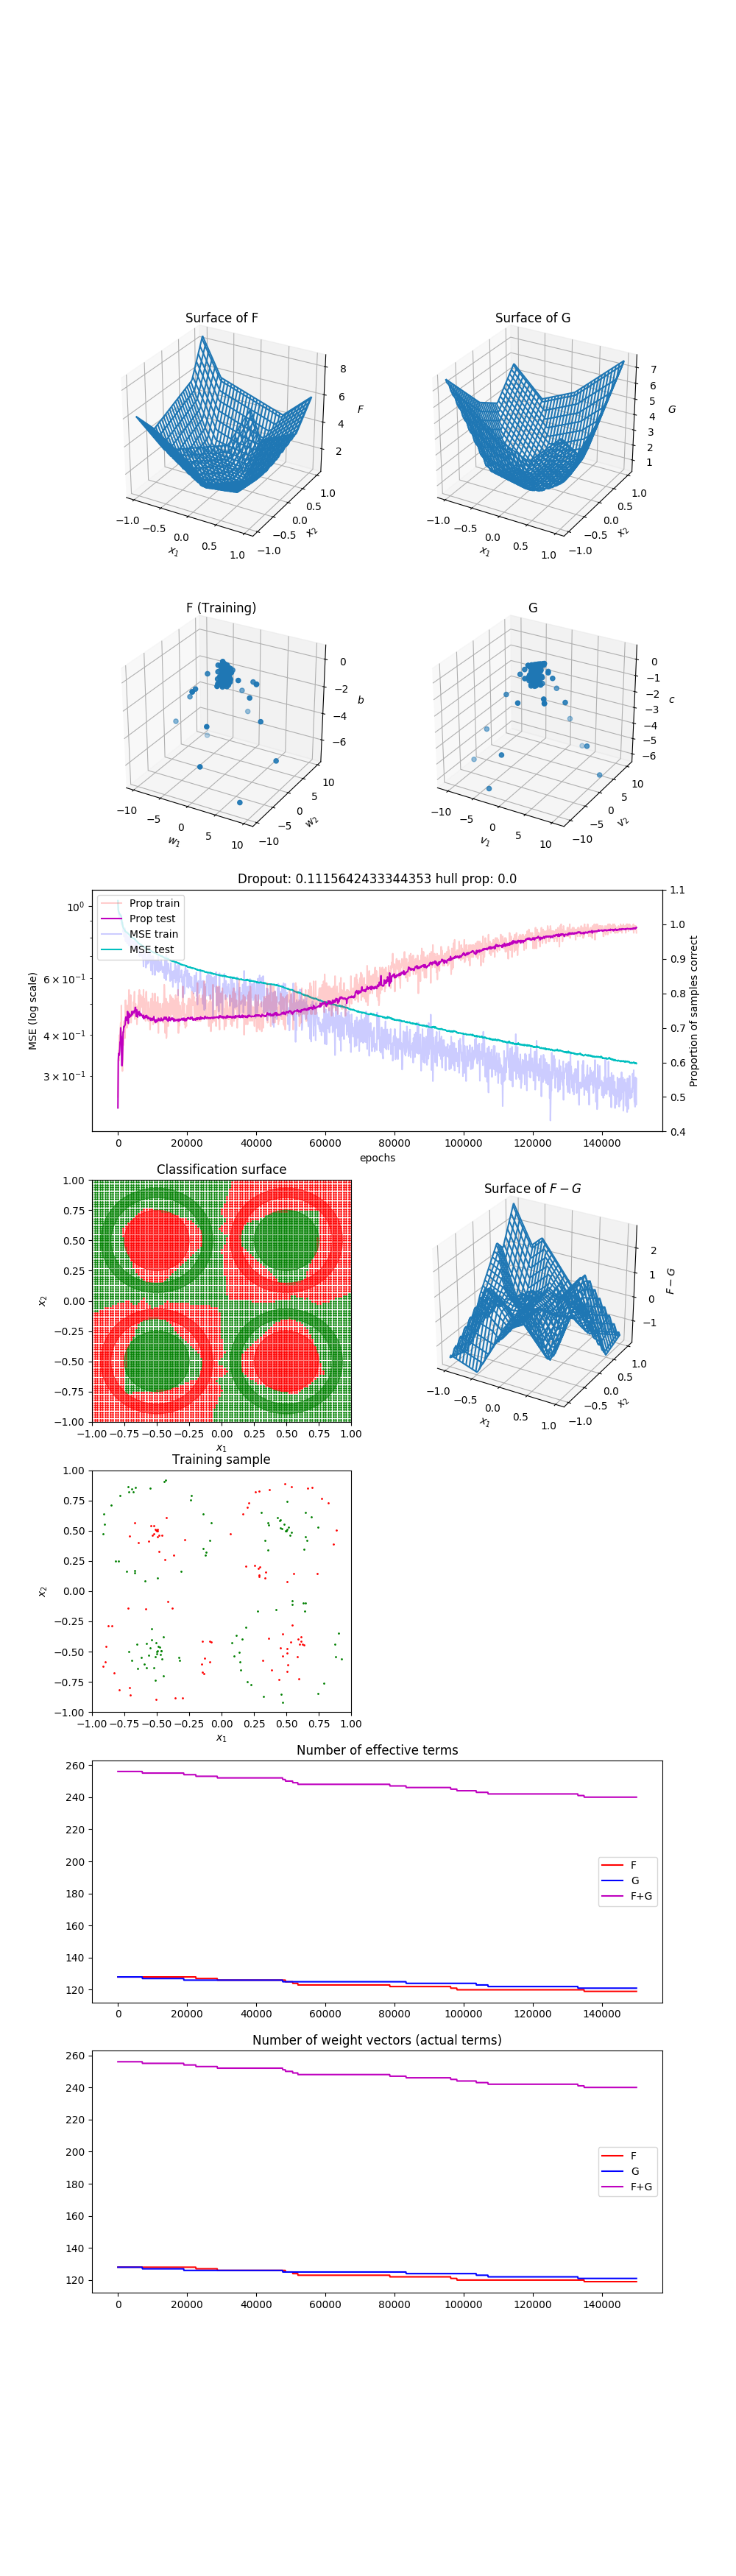

12441.52693772316 seconds to finish


In [9]:
# Training structure
start = time.time()

# Set up plots
fig = plt.figure(figsize=(10, 35))
axWireF = fig.add_subplot(721, projection='3d')
axWireG = fig.add_subplot(722, projection='3d')

axF = fig.add_subplot(723, projection='3d')
axG = fig.add_subplot(724, projection='3d')

axError = fig.add_subplot(713)
axRight = axError.twinx()

axSplit = fig.add_subplot(727)
axFull = fig.add_subplot(728, projection='3d')

axSample = fig.add_subplot(7,2,9)

axTerms = fig.add_subplot(716)
axActualTerms = fig.add_subplot(717)

# Set up metric tracks
errors = []
validation_errors = []
epoch_list = []
training_acc = []
validation_acc = []
num_fterms_list = []
num_gterms_list = []

num_actual_fterms_list = []
num_actual_gterms_list = []

maxAlpha = -float('inf')

numHullUpdates = 0
numNonHullUpdates = 0

perfectTime = 0

for epoch in range(epochs):
    # Update the dropout rate
    initial_dropout_rate *= dropout_change
    
    # Get data
    data, _, _ = data_func(num_samples)
    inputData = data[:, 0:-1]
    outputData = data[:, -1]

    # Forward propogation
    Fresults, Gresults, FLocs, GLocs = evaluate_trops(Fs, Gs, inputData, dropout_rate=initial_dropout_rate)
    result = np.sum(Fresults, axis=0) - np.sum(Gresults, axis=0)
    # Backward propogation
    errorDeriv = outputData - result
    
    # Calculate the convex hulls for the F polynomials
    if doF:
        doHullUpdateF = []
        hullsF = []
        for i in range(len(Fs)):
            doHullUpdateF.append(True)
            temp = None
            try:
                temp = ConvexHull(Fs[i], qhull_options='Qt')
                maxs = np.amax(Fs[i], axis=0)
                mins = np.amin(Fs[i], axis=0)
                Fbox_volume = np.prod(maxs-mins)
                if temp.volume > Fbox_volume:
                    doHullUpdateF[-1] = False
            except QhullError as e:
                doHullUpdateF[-1] = False
            hullsF.append(temp)
    # Calculate the convex hulls for the G polynomials
    if doG:
        doHullUpdateG = []
        hullsG = []
        for i in range(len(Gs)):
            doHullUpdateG.append(True)
            temp = None
            try:
                temp = ConvexHull(Gs[i], qhull_options='Qt')
                maxs = np.amax(Gs[i], axis=0)
                mins = np.amin(Gs[i], axis=0)
                Gbox_volume = np.prod(maxs-mins)
                if temp.volume > Gbox_volume:
                    doHullUpdateG[-1] = False
            except QhullError as e:
                doHullUpdateG[-1] = False
            hullsG.append(temp)
    
    for i in range(len(errorDeriv)):
        if doF:
            for j in range(len(Fs)):
                Findex = FLocs[j][i]
                thisInput = np.concatenate((inputData[i], np.array([1])))
                thisError = errorDeriv[i]
                thisResult = result[i]
                
                fDirect = thisError*thisInput
#                 fNorm = np.linalg.norm(fDirect)
#                 fDirect = fDirect/fNorm
                
                if not doHullUpdateF[j] or Findex in hullsF[j].vertices:
                    fAlpha = 0
                else:
                    fAlpha = rayHullIntersect(Fs[j][Findex], fDirect, hullsF[j])
                    
                if True or 0.001 > 0.5*fAlpha or 0.5*fAlpha>1:
                    fAlpha = 0.001
                    numNonHullUpdates += 1
                else:
                    fAlpha = 0.5*fAlpha#/len(errorDeriv)
                    numHullUpdates += 1
                    
                Fs[j][Findex] = Fs[j][Findex] + fAlpha*fDirect     
        if doG:
            for j in range(len(Gs)):
                Gindex = GLocs[j][i]
                thisInput = np.concatenate((inputData[i], np.array([1])))
                thisError = errorDeriv[i]
                thisResult = result[i]
                
                gDirect = -thisError*thisInput
#                 gNorm = np.linalg.norm(gDirect)
#                 gDirect = gDirect/gNorm
                
                if not doHullUpdateG[j] or Gindex in hullsG[j].vertices:
                    gAlpha = 0
                else:
                    gAlpha = rayHullIntersect(Gs[j][Gindex], gDirect, hullsG[j])
                    
                if True or 0.001 > 0.5*gAlpha or 0.5*gAlpha>1:
                    gAlpha = 0.001
                    numNonHullUpdates += 1
                else:
                    gAlpha = 0.5*gAlpha
                    numHullUpdates += 1
                    
                Gs[j][Gindex] = Gs[j][Gindex] + gAlpha*gDirect
        
        
    # Evaluate on the validation set
    Fresults, Gresults, FLocs, GLocs = evaluate_trops(Fs, Gs, X_test, dropout_rate=0)

    if doF:
        for i in range(len(Fs)):
            # Remove F terms that go unused
            Fremove = set(range(Fs[i].shape[0])) - set(np.unique(FLocs[i]))
            if Fs[i].shape[0] > 0 and len(Fremove) > 0 and np.random.uniform(0, 1, 1) < remove_probability:
                Fs[i] = np.delete(Fs[i], np.random.choice(list(Fremove)), 0)
            # If all Fterms were used, add another
            if Fs[i].shape[0] == len(np.unique(FLocs[i])) and np.random.uniform(0, 1, 1) < growth_probability:
                new_vals = []
                for column in range(Fs[i].shape[1]):
                    valAvg = (np.amin(Fs[i][:, column]) + np.amax(Fs[i][:, column]))/2
                    valRange = (np.amax(Fs[i][:, column]) - np.amin(Fs[i][:, column]))/2
                    new_vals.append(np.random.uniform(valAvg - 0.5*valRange, valAvg + 0.5*valRange, 1))

                Fs[i] = np.append(Fs[i], np.array(new_vals).reshape((1, 3)), axis=0)        
    if doG:
        for i in range(len(Gs)):
            # Remove G terms that go unused
            Gremove = set(range(Gs[i].shape[0])) - set(np.unique(GLocs[i]))
            if Gs[i].shape[0] > 0 and len(Gremove) > 0 and np.random.uniform(0, 1, 1) < remove_probability:
                Gs[i] = np.delete(Gs[i], np.random.choice(list(Gremove)), 0)
            # If all G terms were used, add another
            if Gs[i].shape[0] == len(np.unique(GLocs[i])) and np.random.uniform(0, 1, 1) < growth_probability:
                new_vals = []
                for column in range(Gs[i].shape[1]):
                    valAvg = (np.amin(Gs[i][:, column]) + np.amax(Gs[i][:, column]))/2
                    valRange = (np.amax(Gs[i][:, column]) - np.amin(Gs[i][:, column]))/2
                    new_vals.append(np.random.uniform(valAvg - 0.5*valRange, valAvg + 0.5*valRange, 1))

                Gs[i] = np.append(Gs[i], np.array(new_vals).reshape((1, 3)), axis=0)
    
        
    if (epoch+1) % 1000 == 0:
        doF, doG = doG, doF
    
    
    if (epoch+1) % 100 == 0 or epoch == 0:
        axWireF.clear()
        axWireG.clear()
        axF.clear()
        axG.clear()
        axError.clear()
        axSplit.clear()
        axFull.clear()
        axRight.clear()
        axTerms.clear()
        axActualTerms.clear()
        axSample.clear()
        
        # Calculate training accuracy
        Fresults, Gresults, FLocs, GLocs = evaluate_trops(Fs, Gs, inputData, dropout_rate=0)
        result = np.sum(Fresults, axis=0) - np.sum(Gresults, axis=0)
        training_acc.append(np.sum((result > 0) == (outputData > 0))/(len(outputData)))
        errors.append(np.mean(np.power(outputData - result, 2)))
        epoch_list.append(epoch+1)
        
        # Calculate number of terms
        num_fterms = 1
        num_actual_fterms = 0
        for Fterm in Fs:
            num_actual_fterms += Fterm.shape[0]
            num_fterms *= Fterm.shape[0]
            
        num_gterms = 1
        num_actual_gterms = 0
        for Gterm in Gs:
            num_actual_gterms += Gterm.shape[0]
            num_gterms *= Gterm.shape[0]
            
        num_fterms_list.append(num_fterms)
        num_gterms_list.append(num_gterms)
        num_actual_fterms_list.append(num_actual_fterms)
        num_actual_gterms_list.append(num_actual_gterms)
        
        # Evaluate on the validation set
        Fresults, Gresults, FLocs, GLocs = evaluate_trops(Fs, Gs, X_testCirc, dropout_rate=0)
        result = np.sum(Fresults, axis=0) - np.sum(Gresults, axis=0)
        validationPercent = np.sum((result.reshape((-1, 1)) > 0) == (y_testCirc > 0))/(len(y_testCirc))
        validation_acc.append(validationPercent) 
        validation_errors.append(np.mean(np.power(y_testCirc - result.reshape((-1, 1)), 2)))
        
        if not perfectTime and validationPercent == 1:
            perfectTime = epoch+1
            print('epoch', perfectTime)
            print('time', time.time() - start)
    
        for artist in artists:
            axSplit.add_artist(artist)
        
        Fresults, Gresults, FLocs, GLocs = evaluate_trops(Fs, Gs, X_test, dropout_rate=0)
        Fresult = np.sum(Fresults, axis=0)
        Gresult = np.sum(Gresults, axis=0)
        result = np.sum(Fresults, axis=0) - np.sum(Gresults, axis=0)
        
        axFull.plot_wireframe(X, Y, result.reshape(X.shape))
        axFull.set_title('Surface of $F - G$')
        axFull.set_xlabel('$x_1$')
        axFull.set_ylabel('$x_2$')
        axFull.set_zlabel('$F-G$')
        
        data_gen2.plotClassifierDataAlt(X_test, result, plot=(fig, axSplit))
        axSplit.set_title('Classification surface')
        axSplit.set_xlabel('$x_1$')
        axSplit.set_ylabel('$x_2$')
        
        data_gen2.plotClassifierDataAlt(inputData, outputData, plot=(fig, axSample))
        axSample.set_title('Training sample')
        axSample.set_xlabel('$x_1$')
        axSample.set_ylabel('$x_2$')
        
        axWireF.plot_wireframe(X, Y, Fresult.reshape(X.shape))
        axWireF.set_title('Surface of F')
        axWireF.set_xlabel('$x_1$')
        axWireF.set_ylabel('$x_2$')
        axWireF.set_zlabel('$F$')
        axWireG.plot_wireframe(X, Y, Gresult.reshape(X.shape))
        axWireG.set_title('Surface of G')
        axWireG.set_xlabel('$x_1$')
        axWireG.set_ylabel('$x_2$')
        axWireG.set_zlabel('$G$')
        
        if num_fterms < 2000:
            Fterms = Fs[0][:]
            for i in range(1, len(Fs)):
                FtermsTemp = Fterms[:] + Fs[i][0, :]
                for j in range(1, Fs[i].shape[0]):
                    FtermsTemp = np.vstack((FtermsTemp, Fterms + Fs[i][j, :]))
                Fterms = FtermsTemp
            axF.scatter(Fterms[:, 0], Fterms[:, 1], zs=Fterms[:, 2])
            
        if num_gterms < 2000:
            Gterms = Gs[0][:]
            for i in range(1, len(Gs)):
                GtermsTemp = Gterms[:] + Gs[i][0, :]
                for j in range(1, Gs[i].shape[0]):
                    GtermsTemp = np.vstack((GtermsTemp, Gterms + Gs[i][j, :]))
                Gterms = GtermsTemp
            axG.scatter(Gterms[:, 0], Gterms[:, 1], zs=Gterms[:, 2])
        
        if doF:
            axF.set_title('F (Training)')
        else:
            axF.set_title('F')
        
        if doG:
            axG.set_title('G (Training)')
        else:
            axG.set_title('G')
            
        axF.set_xlabel('$w_1$')
        axF.set_ylabel('$w_2$')
        axF.set_zlabel('$b$')
        
        axG.set_xlabel('$v_1$')
        axG.set_ylabel('$v_2$')
        axG.set_zlabel('$c$')
        
        axError.semilogy(epoch_list, errors, 'b', alpha=0.2)
        axError.semilogy(epoch_list, validation_errors, 'c')
        axError.set_title('Dropout: ' + str(initial_dropout_rate) + ' hull prop: ' + str(numHullUpdates/(numHullUpdates + numNonHullUpdates)))
        axError.set_xlabel('epochs')
        axError.set_ylabel('MSE (log scale)')
        
        axRight.plot(epoch_list, training_acc, 'r', label='Prop train', alpha=0.2)
        axRight.plot(epoch_list, validation_acc, c='m', label='Prop test')
        axRight.set_ylim([0.4, 1.1])
    
        axRight.plot([0], [0], 'b', label='MSE train', alpha=0.2)
        axRight.plot([0], [0], 'c', label='MSE test')
        
        if perfectTime:
            #remove_probability = 0.1
            axRight.plot([perfectTime, perfectTime], [0, 2], 'k')
    
        axRight.legend()
    
        axRight.set_ylabel('Proportion of samples correct')
        
        axTerms.plot(epoch_list, num_fterms_list, 'r', label='F')
        axTerms.plot(epoch_list, num_gterms_list, 'b', label='G')
        axTerms.plot(epoch_list, [num_fterms_list[i] + num_gterms_list[i] for i in range(len(num_fterms_list))], 'm', label='F+G')
        axTerms.set_title('Number of effective terms')
        axTerms.legend()
        
        axActualTerms.plot(epoch_list, num_actual_fterms_list, 'r', label='F')
        axActualTerms.plot(epoch_list, num_actual_gterms_list, 'b', label='G')
        axActualTerms.plot(epoch_list, [num_actual_fterms_list[i] + num_actual_gterms_list[i] for i in range(len(num_actual_fterms_list))], 'm', label='F+G')
        axActualTerms.set_title('Number of weight vectors (actual terms)')
        axActualTerms.legend()
        
        fig.canvas.draw()
        fig.canvas.flush_events()

print(time.time() - start, 'seconds to finish')

In [10]:
# Fterms = Fs[0][:]
# for i in range(1, len(Fs)):
#     FtermsTemp = Fterms[:] + Fs[i][0, :]
#     for j in range(1, Fs[i].shape[0]):
#         FtermsTemp = np.vstack((FtermsTemp, Fterms + Fs[i][j, :]))
#     Fterms = FtermsTemp
# axF.scatter(Fterms[:, 0], Fterms[:, 1], zs=Fterms[:, 2])

# Gterms = Gs[0][:]
# for i in range(1, len(Gs)):
#     GtermsTemp = Gterms[:] + Gs[i][0, :]
#     for j in range(1, Gs[i].shape[0]):
#         GtermsTemp = np.vstack((GtermsTemp, Gterms + Gs[i][j, :]))
#     Gterms = GtermsTemp
# axG.scatter(Gterms[:, 0], Gterms[:, 1], zs=Gterms[:, 2])

In [11]:
import dill
dill.dump_session('tropicalTrain/onlyConvex.db')
#dill.dump_session('tropicalTrain/useNone.db')
#dill.load_session('tropicalTrain/useAll.db')